### Modeling and visualizing dynamics of state COVID cases 

#### Anna Konstorum (konstorum.anna@gmail.com)

In [1]:
# import packages
import datetime
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D
%matplotlib inline

In [2]:
print(f'Last updated: {datetime.date.today()}')

Last updated: 2020-03-28


In [3]:
# import latest state data
url='https://covidtracking.com/api/states/daily.csv'
state_data=pd.read_csv(url,sep=',',header='infer', parse_dates=[0])

In [4]:
# create exponential function to model 
# will add additional functions shortly

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

def quad_func(x,a,b,c):
    return a*x**2 +b*x+c

def lin_func(x,a,b):
    return a*x + b

In [5]:
def SSE_curve(x,y,fxn):
    popt,pop = curve_fit(fxn,x,y)
    y_exp= fxn(x, *popt)
    SSE = sum((y-y_exp)**2)
    return popt,SSE

In [6]:
# filter for IL
IL_data = state_data[state_data["state"]=="IL"]
IL_data=IL_data.sort_values(by="date")
IL_data.reset_index(inplace=True,drop=True)

In [7]:
# date range of the graph
start_date = min(IL_data['date'])
end_date = max(IL_data['date'])
next_date=end_date+datetime.timedelta(days=1)

print(f'Data from {start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}')

Data from 2020-03-04 to 2020-03-27


In [8]:
# Textual date for labels
tomorrow_label = (end_date + datetime.timedelta(days=1)).strftime('%m/%d')

# get current date range
date_range=pd.date_range(start=start_date, end=end_date)
date_range_plus=pd.date_range(start=start_date,end=next_date)

# output date range as list
dates = [date.strftime('%m/%d') for date in date_range_plus]

In [9]:
# model fit for positive cases
xdata=np.array(IL_data.index)[-10:]

data_to_model=["positive"]
model_results=pd.DataFrame(index=data_to_model,columns=['a','b','c'])
xdata=np.array(IL_data.index)[-10:]
for item in data_to_model:
    ydata=np.array(IL_data[item])[-10:]
    
    popt_exp, SSE_exp = SSE_curve(xdata,ydata,exp_func)
    popt_quad,SSE_quad = SSE_curve(xdata,ydata,quad_func)
    popt_lin,SSE_lin = SSE_curve(xdata,ydata,lin_func)
    
    min_error=min(SSE_exp,SSE_quad,SSE_lin)
    
    if min_error == SSE_exp:
        model_results.loc[item,['a','b','c']]=popt_exp
        model_results.loc[item,'model']='exp'
    elif min_error == SSE_quad:
        model_results.loc[item,['a','b','c']]=popt_quad
        model_results.loc[item,'model']='quad'
    elif min_error == SSE_lin:
        model_results.loc[county,['a','b']]=popt_lin
        model_results.loc[county,'model']='lin'

In [10]:
# Include all dates, even those with missing data
xdata_full=np.array(range(len(dates)))
xdata_pred=np.array(range(len(dates)))[-11:]

In [11]:
#func use
def function_use(county,model_results):
    if model_results.loc[county]["model"]=='exp':
        func_use=exp_func
        opt_model = 'exponential'
    elif model_results.loc[county]["model"]=='quad':
        func_use=quad_func
        opt_model = 'quadratic'
    else:
        func_use=lin_func
        opt_model = 'linear'
    return func_use, opt_model

### Illinois model and dynamics

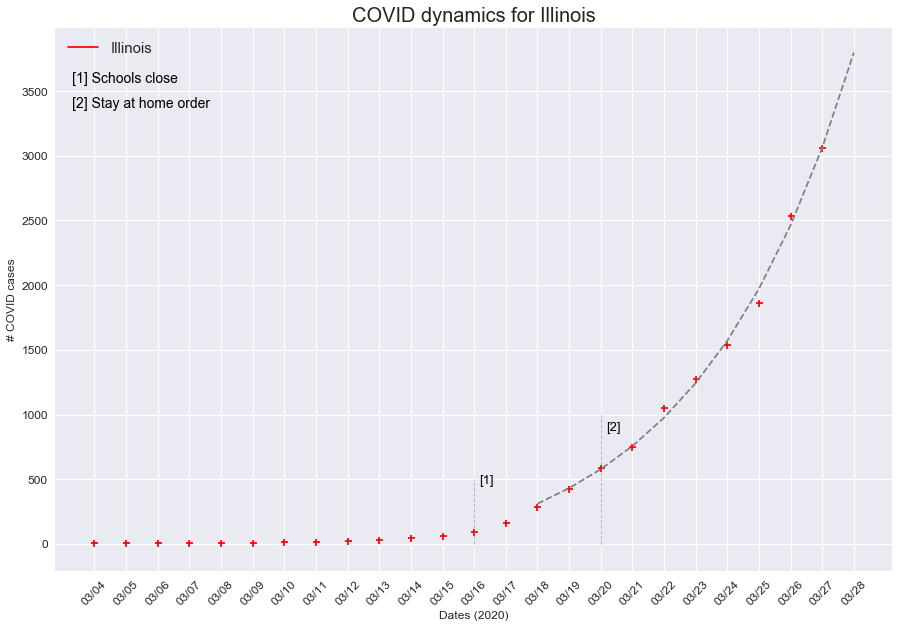

In [12]:
legend_elements =  [Line2D([0], [0], marker='+', color='red', label='Illinois', markersize=15)]

popt_state = model_results.loc["positive"][0:3]

func_use, opt_model = function_use("positive",model_results)

plt.figure(figsize=(15,10))

plt.plot(xdata_pred, exp_func(xdata_pred, *popt_state), color='grey',linestyle='--');
plt.scatter(IL_data.index,IL_data['positive'],color='red',marker='+');

#plt.vlines(x=0, ymin=0, ymax=50,color='dimgrey', linewidth=0.5,linestyle='-.');
#plt.text(0.4,40,"[1]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=12, ymin=0, ymax=500,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(12.4,490,"[1]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=16, ymin=0, ymax=1000,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(16.4,900,"[2]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');


#plt.text(-0.7,360,"[1] First cases in Maryland",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='left');
plt.text(-0.7,3600,"[1] Schools close",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='left');
plt.text(-0.7,3400,"[2] Stay at home order",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='left');

plt.ylabel('# COVID cases',fontsize=12);
plt.xticks(xdata_full, dates, rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=12)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.title("COVID dynamics for Illinois",fontsize=20);
   

In [13]:
# Predict next day's cases
next_day = xdata_pred[-1]
next_day_cases = exp_func(next_day, popt_state[0], popt_state[1], popt_state[2])
print(f"The best model for Illinois is the {opt_model} model.  Prediction for number of total cases for {tomorrow_label} is {int(next_day_cases)}.")

The best model for Illinois is the exponential model.  Prediction for number of total cases for 03/28 is 3798.
